This notebook will look for the following pattern:
- WT not associated with time.
    - P > 0.05 and abs log2FC < log2(1.5)
- MUT associated with time.
    - P < 0.05 and abs log2FC > 1

The bottom line is that no comparison is taken between WT and MUT at neither initial nor last time points. So, if initial conditions do not match it is OK and also, situations such that MUT reaches the flat WT are also OK.

In [1]:
import pandas, numpy, termcolor
import scipy, scipy.stats

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
DEG_folder = '/home/adrian/projects/reynisfjara/results/DEGs_DESeq2/strict/'
expression_file = '/home/adrian/projects/reynisfjara/results/tpm/DESeq2_TPM_values.tsv'

annotation_file = '/home/adrian/projects/reynisfjara/results/annotation/annotation.csv'

mice = ['a3922', 'a4774', 'a4775', 'a4776']
times = ['0h', '48h', '72h']
numerical_times = [0, 48, 72]

# 1. read data

## 1.1. read expression

In [4]:
expression = pandas.read_csv(expression_file, sep='\t', index_col=0)
expression.head()

,a3922_0h_1,a3922_0h_2,a3922_0h_3,a3922_48h_1,a3922_48h_2,a3922_48h_3,a3922_72h_1,a3922_72h_2,a3922_72h_3,a4774_0h_1,...,a4775_72h_3,a4776_0h_1,a4776_0h_2,a4776_0h_3,a4776_48h_1,a4776_48h_2,a4776_48h_3,a4776_72h_1,a4776_72h_2,a4776_72h_3
ENSMUSG00000000001,65.244411,65.953285,64.396929,75.289955,71.147817,72.146832,67.786762,70.217188,70.219265,61.227221,...,68.440778,64.806231,65.619286,66.749396,64.425407,68.665136,68.419059,69.705546,70.717428,71.017699
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.945436,5.464240,4.924612,20.245428,19.780706,22.747363,19.239938,22.062649,20.547492,7.843197,...,14.565935,4.712688,3.690099,4.120889,7.220914,8.377850,9.611563,9.465468,10.235803,9.808747
ENSMUSG00000000037,0.220972,0.959207,0.258270,0.969948,1.149452,2.212842,0.989879,2.354492,1.813624,0.545637,...,0.989086,0.451844,0.523639,0.679725,2.862086,0.865126,1.973570,1.612622,2.148935,5.445061
ENSMUSG00000000049,0.061451,0.061879,0.096945,0.000000,0.071373,0.000000,0.059768,0.000000,0.000000,0.214027,...,0.761343,0.000000,0.125876,0.000000,0.000000,0.096454,0.130578,0.000000,0.000000,0.000000


## 1.2. read annotation

In [5]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(53193, 3)


,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


# 2. transform expression to be more amenable to downstream analysis

In [6]:
df = pandas.DataFrame()
for mouse in mice:
    for time in times:
        condition_labels = [label for label in expression.columns if mouse in label and time in label]
        df[mouse + '_' + time] = expression.loc[:, condition_labels].median(axis=1)
df.head()

,a3922_0h,a3922_48h,a3922_72h,a4774_0h,a4774_48h,a4774_72h,a4775_0h,a4775_48h,a4775_72h,a4776_0h,a4776_48h,a4776_72h
ENSMUSG00000000001,65.244411,72.146832,70.217188,61.227221,65.197716,64.804086,55.869249,65.371837,68.440778,65.619286,68.419059,70.717428
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.464240,20.245428,20.547492,7.843197,8.262456,11.467644,8.258439,15.989181,16.179836,4.120889,8.377850,9.808747
ENSMUSG00000000037,0.258270,1.149452,1.813624,0.567393,1.344796,1.122762,0.472029,0.958435,1.713961,0.523639,1.973570,2.148935
ENSMUSG00000000049,0.061879,0.000000,0.000000,0.214027,0.000000,0.000000,0.149524,0.000000,0.441745,0.000000,0.096454,0.000000


In [7]:
for label in df.columns:
    if 'a3922' in label:
        new_label = 'WT_' + label.split('_')[1]
        df.rename(columns = {label:new_label}, inplace=True)
df.head()

,WT_0h,WT_48h,WT_72h,a4774_0h,a4774_48h,a4774_72h,a4775_0h,a4775_48h,a4775_72h,a4776_0h,a4776_48h,a4776_72h
ENSMUSG00000000001,65.244411,72.146832,70.217188,61.227221,65.197716,64.804086,55.869249,65.371837,68.440778,65.619286,68.419059,70.717428
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.464240,20.245428,20.547492,7.843197,8.262456,11.467644,8.258439,15.989181,16.179836,4.120889,8.377850,9.808747
ENSMUSG00000000037,0.258270,1.149452,1.813624,0.567393,1.344796,1.122762,0.472029,0.958435,1.713961,0.523639,1.973570,2.148935
ENSMUSG00000000049,0.061879,0.000000,0.000000,0.214027,0.000000,0.000000,0.149524,0.000000,0.441745,0.000000,0.096454,0.000000


In [8]:
simple_expression = df.iloc[:, :3]
simple_expression.head()

,WT_0h,WT_48h,WT_72h
ENSMUSG00000000001,65.244411,72.146832,70.217188
ENSMUSG00000000003,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.464240,20.245428,20.547492
ENSMUSG00000000037,0.258270,1.149452,1.813624
ENSMUSG00000000049,0.061879,0.000000,0.000000


In [9]:
simple_expression = df.iloc[:, :3]

for time in times:
    condition_labels = [label for label in df.columns if time in label and 'WT' not in label]
    simple_expression['MUT_' + time] = df.loc[:, condition_labels].median(axis=1)

simple_expression.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
ENSMUSG00000000001,65.244411,72.146832,70.217188,61.227221,65.371837,68.440778
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.464240,20.245428,20.547492,7.843197,8.377850,11.467644
ENSMUSG00000000037,0.258270,1.149452,1.813624,0.523639,1.344796,1.713961
ENSMUSG00000000049,0.061879,0.000000,0.000000,0.149524,0.000000,0.000000


# 3. search for pattern

## 3.1. retrieve genes that change with time in MUT phenotype

In [10]:
DEGs = []
for mouse in mice[1:]:
    path = DEG_folder + 'strict_MUTt72_over_MUTt0_' + mouse + '.tsv'
    df = pandas.read_csv(path, sep='\t', index_col=0)
    print(df.shape)
    DEGs.append(df.index.to_list())
list_one = list(set(DEGs[0]) & set(DEGs[1]) & set(DEGs[2]))
print(len(list_one))

(468, 6)
(1049, 6)
(1056, 6)
218


In [11]:
# filter out genes that do not cross the abs log2FC > 1 and the max. expr. > 2
list_one_a = []
for ensembl in list_one:
    working_expression = simple_expression.loc[ensembl, :]
    #print(working_expression)
    start = numpy.round(simple_expression.loc[ensembl, 'MUT_0h']) + 1
    end = numpy.round(simple_expression.loc[ensembl, 'MUT_72h']) + 1
    #print(start, end)
    abs_log2FC = numpy.abs(numpy.log2(end/start))
    #print(abs_log2FC)
    
    max_expr = numpy.max([start, end])
    
    if abs_log2FC > 1 and max_expr > 2+1:
        list_one_a.append(ensembl)
        
print(len(list_one_a))

142


## 3.2. check that genes are WT flat

In [12]:
path = DEG_folder + 'strict_WTt72_over_WTt0' + '.tsv'
df = pandas.read_csv(path, sep='\t', index_col=0)
print(df.shape)
DEGs = df.index.to_list()
list_four = list(set(DEGs))
print(len(list_four))

(1383, 6)
1383


In [13]:
# a flat gene is a gene that:
# if has low expression (TPM < 2)
# elif abs log2FC < log(1.5) and not in significant group

list_four_a = []
for ensembl in simple_expression.index:
    start = numpy.round(simple_expression.loc[ensembl, 'WT_0h']) + 1
    end = numpy.round(simple_expression.loc[ensembl, 'WT_72h']) + 1
    max_expr = numpy.max([start, end])
    abs_log2FC = numpy.abs(numpy.log2(end/start))
    
    if max_expr < 2+1:
        list_four_a.append(ensembl)
    if abs_log2FC < numpy.log2(1.5) and ensembl not in list_four:
        #print('\t', abs_log2FC, ensembl in list_four)
        list_four_a.append(ensembl)
        
list_four_b = list(set(list_four_a))
print(len(simple_expression.index), len(list_four_a), len(list_four_b))

35938 56784 33227


## 3.3. define gene set such that MUT changes and WT does not

In [14]:
list_five = []
for ensembl in list_one_a:
    if ensembl in list_four_b:
        list_five.append(ensembl)
print(len(list_five))

31


# 4. plot and print identified genes

## 4.1. print selected set of genes

In [15]:
for ensembl in list_five:
    gene_name = annotation.loc[ensembl]['ext_gene']
    description = annotation.loc[ensembl]['description'].split(' [')[0]
    if simple_expression.loc[ensembl, 'MUT_72h'] > simple_expression.loc[ensembl, 'MUT_0h']:
        trend = 'up'
        message = '\t'.join([ensembl, gene_name, trend, description])
        print(termcolor.colored(message, 'red'))
    else:
        trend = 'down'
        message = '\t'.join([ensembl, gene_name, trend, description])
        print(termcolor.colored(message, 'blue'))

ENSMUSG00000016496	Cd274	up	CD274 antigen
ENSMUSG00000023009	Nckap5l	down	NCK-associated protein 5-like
ENSMUSG00000022243	Slc45a2	down	solute carrier family 45, member 2
ENSMUSG00000030796	Tead2	up	TEA domain family member 2
ENSMUSG00000046727	Cystm1	down	cysteine-rich transmembrane module containing 1
ENSMUSG00000030084	Plxna1	down	plexin A1
ENSMUSG00000074892	B3galt5	down	UDP-Gal:betaGlcNAc beta 1,3-galactosyltransferase, polypeptide 5
ENSMUSG00000001751	Naglu	down	alpha-N-acetylglucosaminidase (Sanfilippo disease IIIB)
ENSMUSG00000107874	Prpmp5	down	proline-rich protein MP5
ENSMUSG00000028713	Cyp4b1	up	cytochrome P450, family 4, subfamily b, polypeptide 1
ENSMUSG00000029510	Gpc2	up	glypican 2 (cerebroglycan)
ENSMUSG00000021696	Elovl7	down	ELOVL family member 7, elongation of long chain fatty acids (yeast)
ENSMUSG00000026857	Ntmt1	down	N-terminal Xaa-Pro-Lys N-methyltransferase 1
ENSMUSG00000006235	Epor	up	erythropoietin receptor
ENSMUSG00000059013	Sh2d3c	up	SH2 domain containing 3C

In [16]:
## 4.2. generate trajectory plots

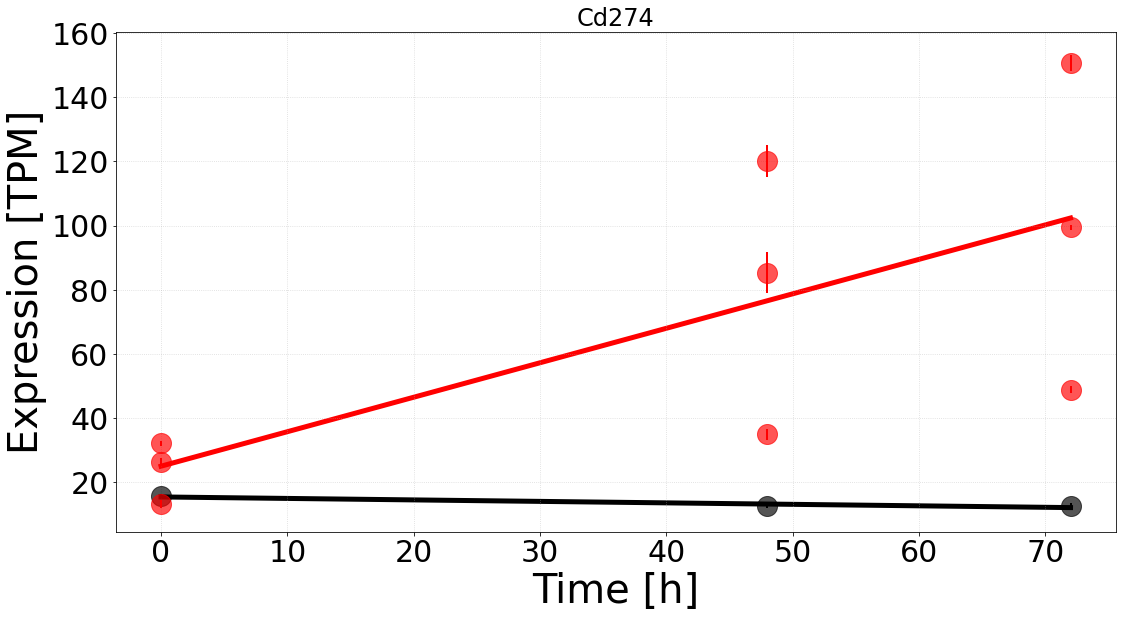

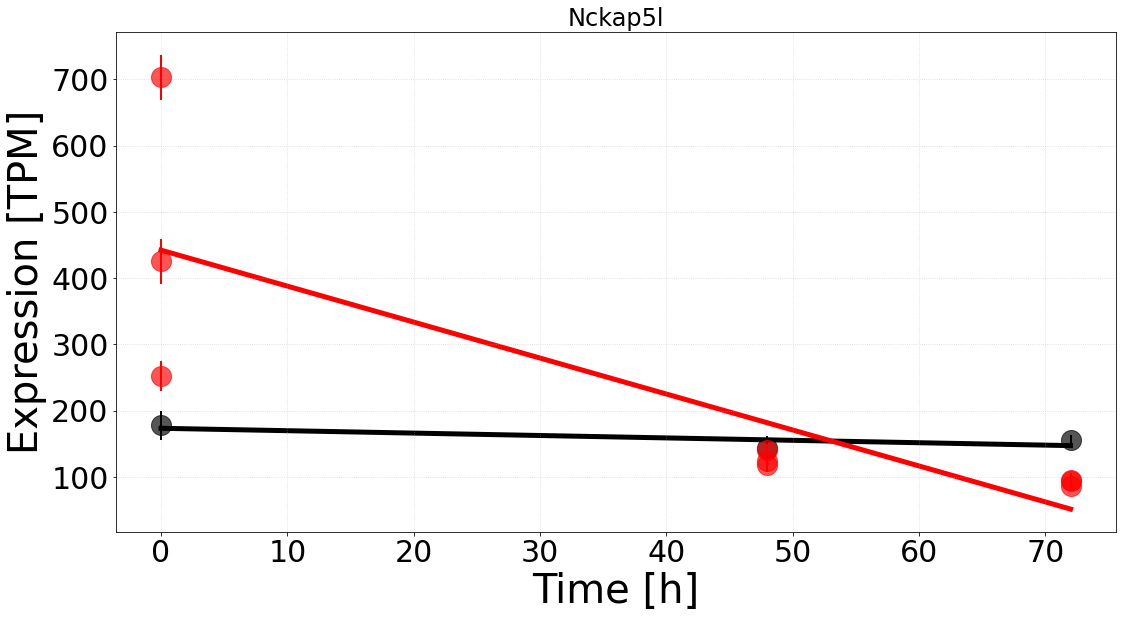

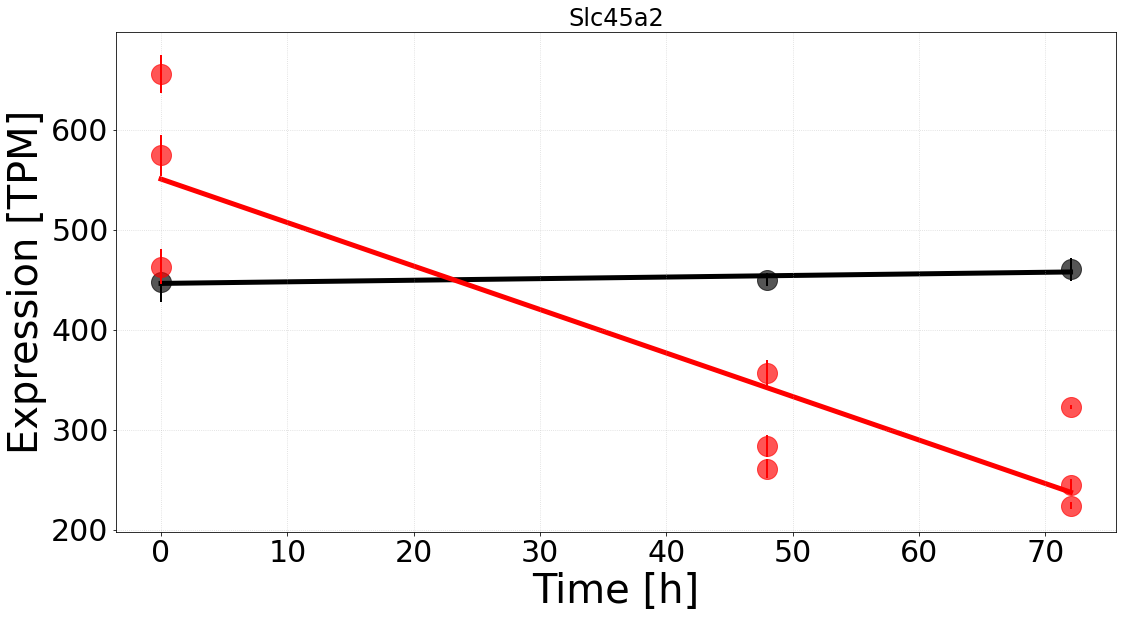

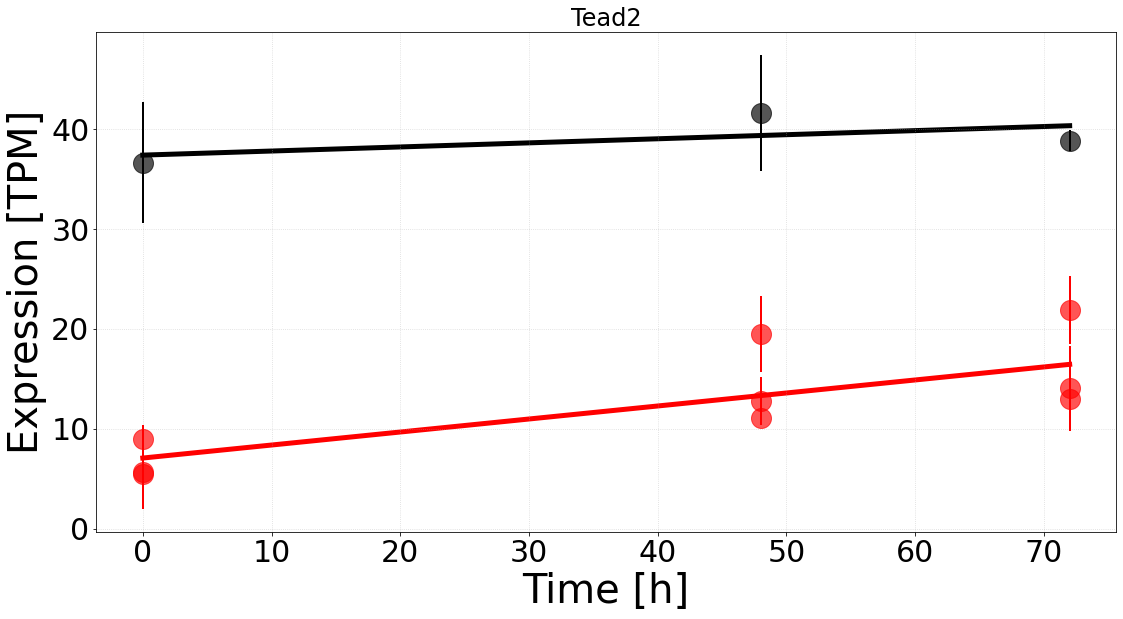

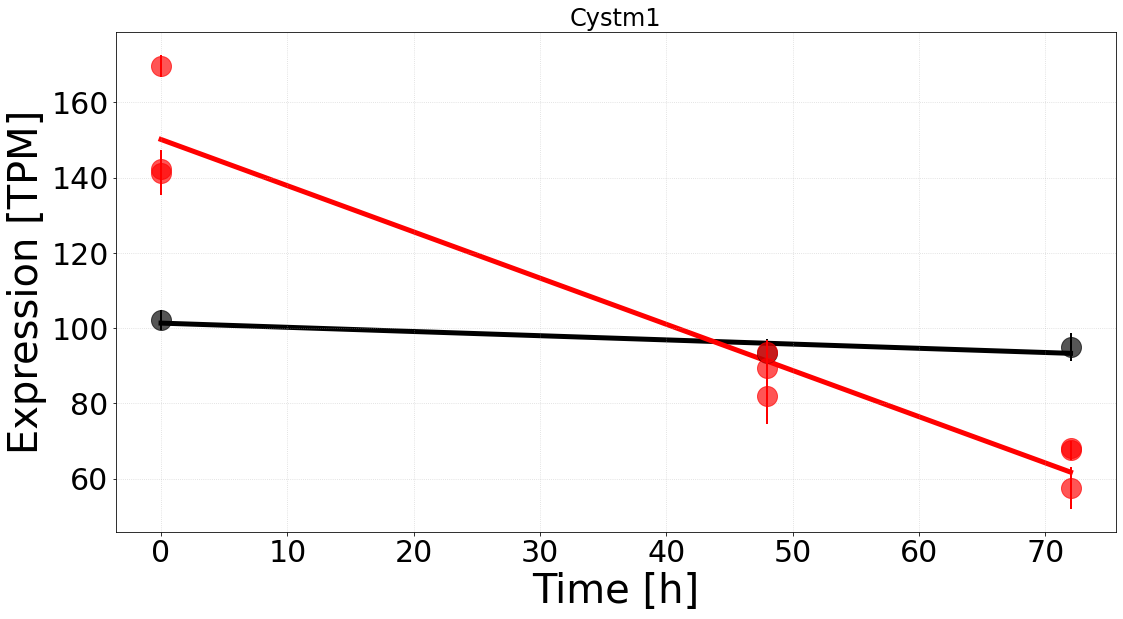

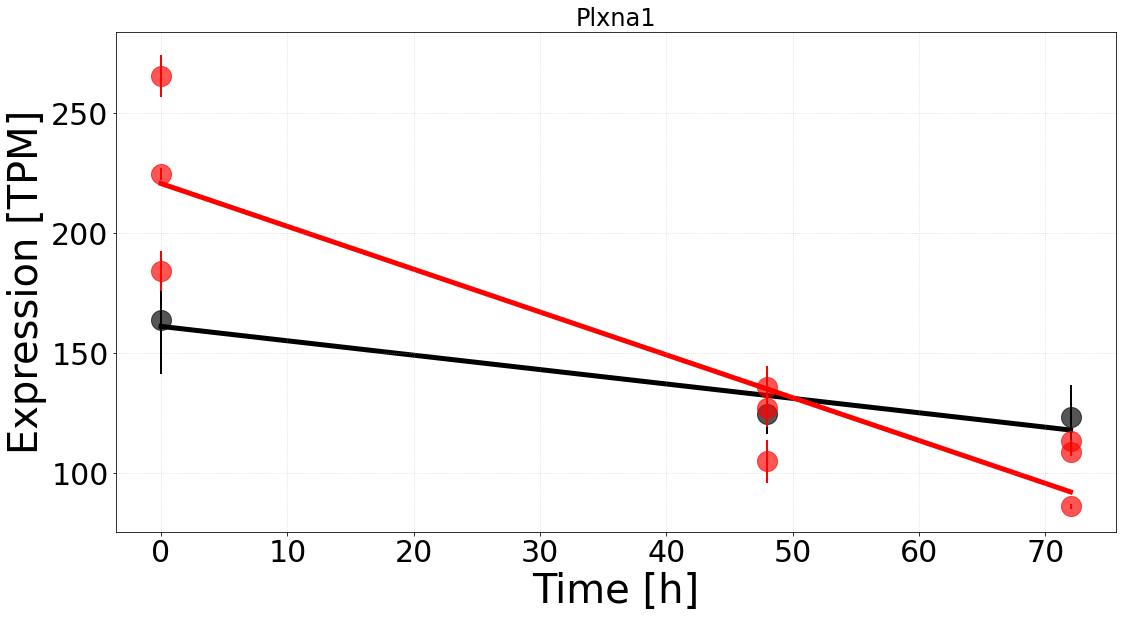

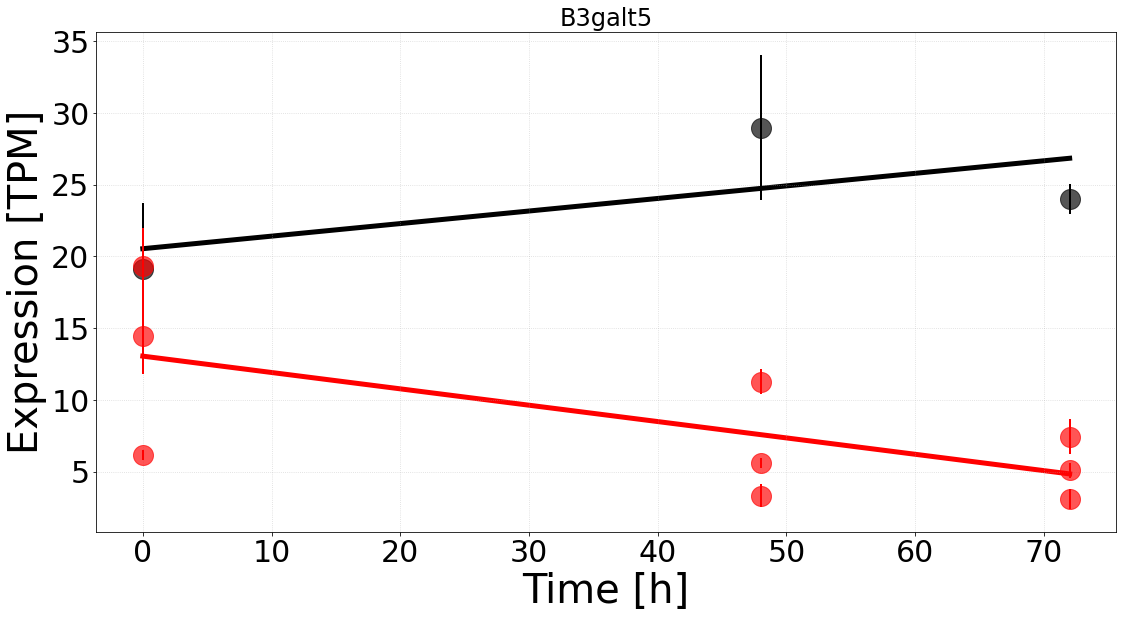

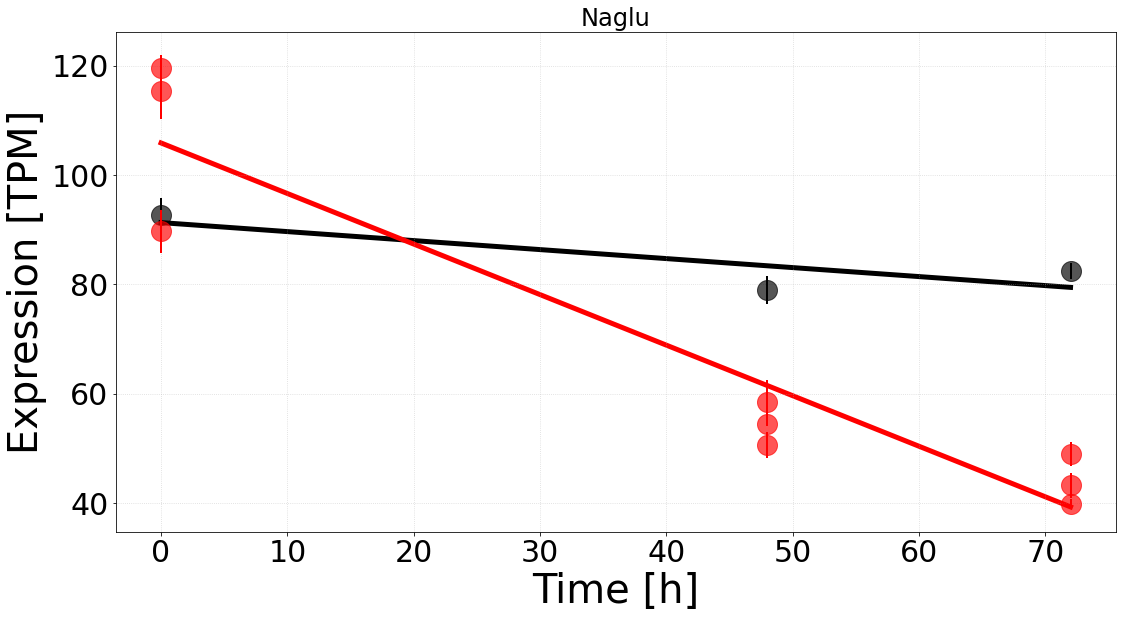

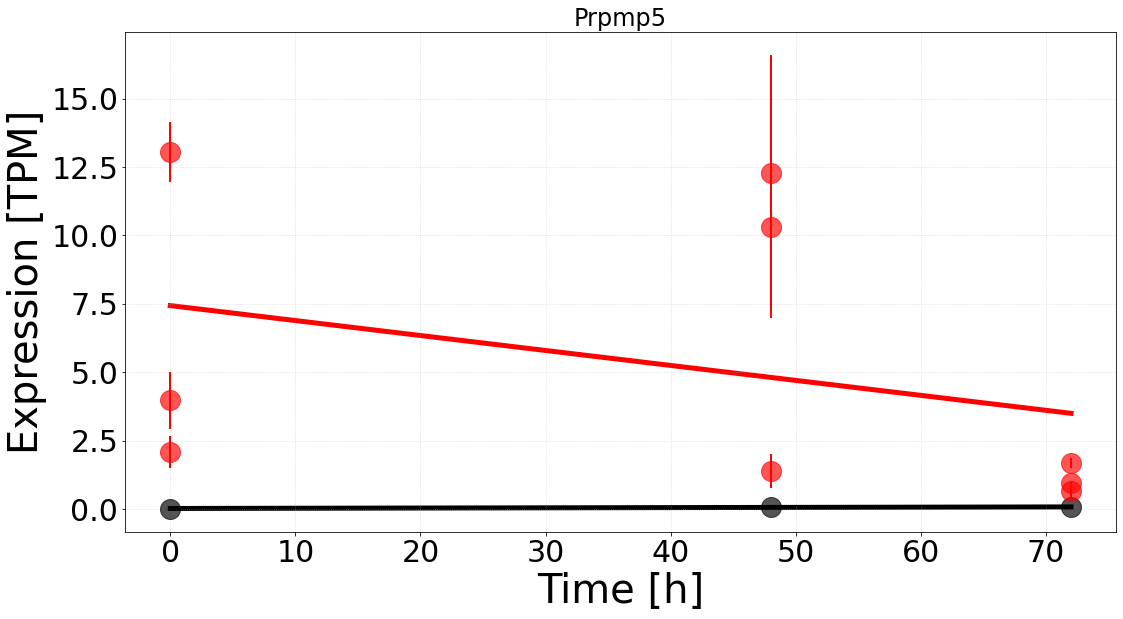

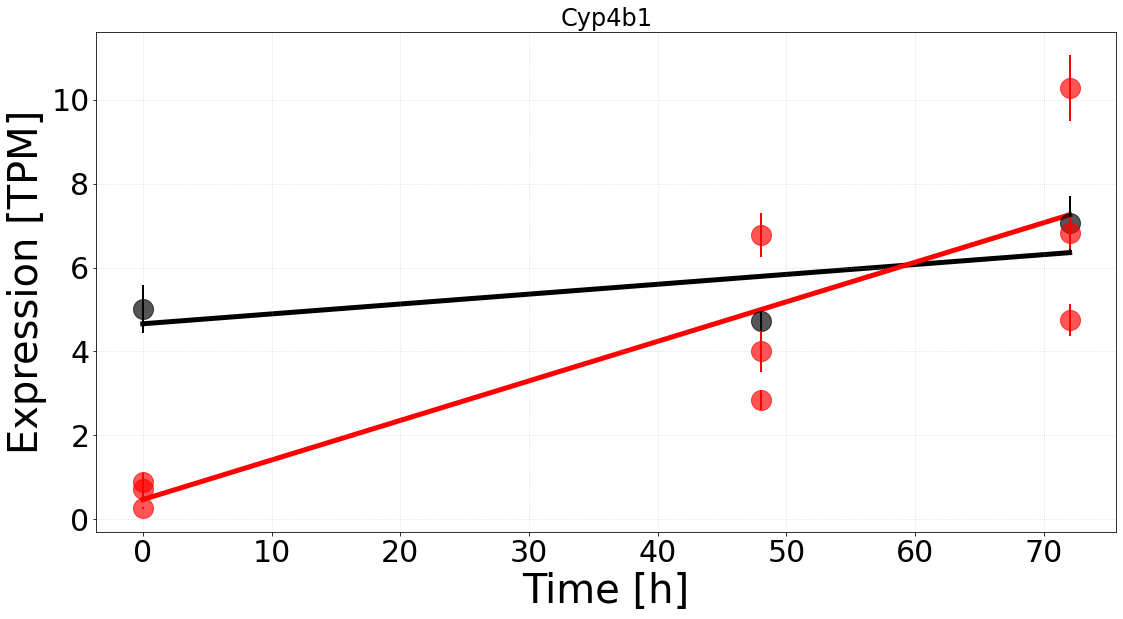

In [17]:
expression_labels = expression.columns
wt_labels = [label for label in simple_expression.columns if 'WT' in label]
mut_labels = [label for label in simple_expression.columns if 'MUT' in label]

for ensembl in list_five[:10]:
    gene_name = annotation.loc[ensembl]['ext_gene']
    ensembl_trajectory = []; ensembl_times = []
    
    for mouse in mice:
        plotting_means = []
        plotting_stds = []
        
        for time in times:
            working_labels = [label for label in expression_labels if mouse in label and time in label]
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
            for value in values.to_list():
                ensembl_trajectory.append(value)
                ensembl_times.append(int(time.split('h')[0]))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        else:
            the_color = 'red'
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=2)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20, alpha=2/3)
        
    #print('ensembl trajetory', ensembl_trajectory)
    #print('ensembl times', ensembl_times)
    
    # interpolation
    x = ensembl_times[:9]
    y = ensembl_trajectory[:9]
    #print('xWT', x)
    #print('yWT', y)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='black', lw=5, zorder=0)
    
    x = ensembl_times[9:]
    y = ensembl_trajectory[9:]
    #print('xMUT', x)
    #print('yMUT', y)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='red', lw=5, zorder=0)
    
    # store info for z-score heatmap.
    
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name)
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

## 4.3. generate heatmap on z-score

## 4.4. pseudo volcano plot